In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax

print('Modules loaded')

Modules loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/My Drive/braintumords"
tr_df_path = os.path.join(dataset_path, "Training")
tst_df_path = os.path.join(dataset_path, "Testing")

In [ ]:
def load_dataset(folder_path):
    labels = []
    filepaths = []

    for fold in os.listdir(folder_path):  # Iterate over class folders
        foldpath = os.path.join(folder_path, fold)
        for file in os.listdir(foldpath):  # Iterate over images in folder
            filepath = os.path.join(foldpath, file)
            labels.append(fold)
            filepaths.append(filepath)

    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

# Load training and testing data
tr_df = load_dataset(tr_df_path)
ts_df = load_dataset(tst_df_path)

# Display dataset statistics
print(f"Training Dataset Size: {tr_df.shape}")
print(f"Testing Dataset Size: {ts_df.shape}")


Training Dataset Size: (5712, 2)
Testing Dataset Size: (1311, 2)


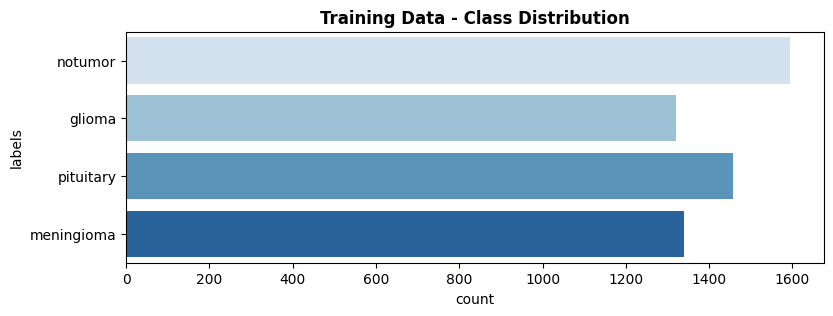

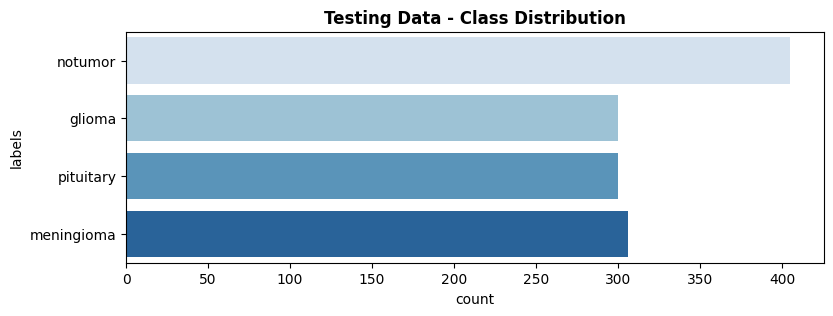

In [ ]:
plt.figure(figsize=(9,3))
sns.countplot(data=tr_df, y="labels", palette='Blues')
plt.title("Training Data - Class Distribution", weight="bold")
plt.show()

plt.figure(figsize=(9,3))
sns.countplot(data=ts_df, y="labels", palette='Blues')
plt.title("Testing Data - Class Distribution", weight="bold")
plt.show()

In [ ]:
valid_df, tst_df = train_test_split(ts_df, test_size=0.5, random_state=50, stratify=ts_df["labels"])
print(f"Validation Data: {valid_df.shape}, Test Data: {tst_df.shape}")

# Image Data Generators
img_size = (224, 224)
batch_size = 16

tr = ImageDataGenerator()
ts = ImageDataGenerator()

train_gen = tr.flow_from_dataframe(tr_df, x_col="filepaths", y_col="labels",
                                   target_size=img_size, batch_size=batch_size,
                                   shuffle=True, class_mode='categorical', color_mode="rgb")

valid_gen = ts.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                   target_size=img_size, class_mode="categorical",
                                   color_mode="rgb", shuffle=True, batch_size=batch_size)

test_gen = ts.flow_from_dataframe(tst_df, x_col='filepaths', y_col='labels',
                                  target_size=img_size, batch_size=batch_size,
                                  shuffle=False, color_mode="rgb", class_mode="categorical")


Validation Data: (655, 2), Test Data: (656, 2)
Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


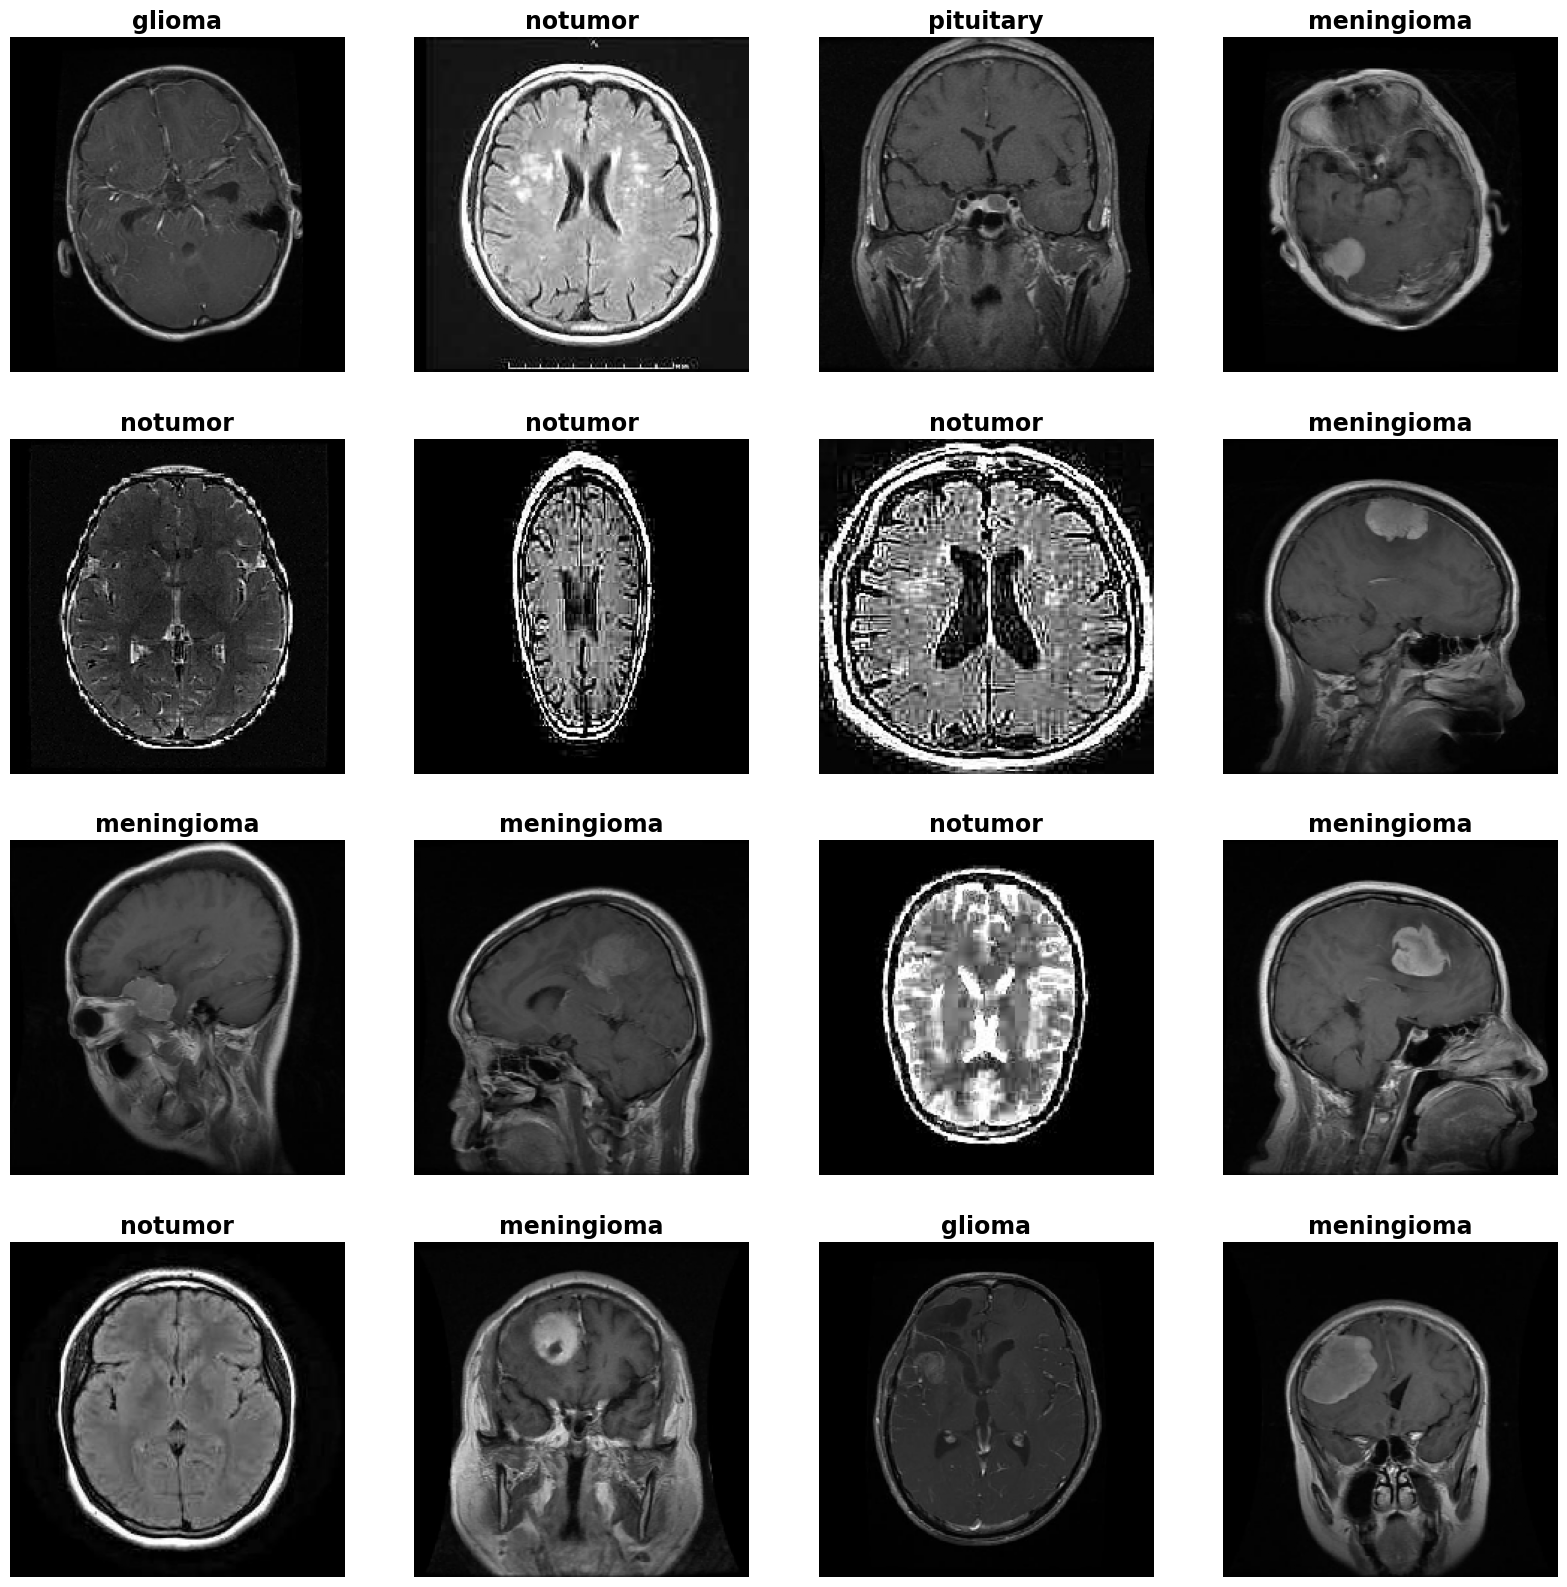

In [ ]:
classes = list(train_gen.class_indices.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i] / 255)
    class_name = classes[np.argmax(labels[i])]
    plt.title(class_name, fontsize=17, weight="bold")
    plt.axis('off')
plt.show()


In [ ]:
img_shape = (224, 224, 3)
base_Model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

Model = Sequential([
    base_Model,
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(len(classes), activation='softmax')
])

Model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3308s 9s/step - accuracy: 0.8873 - loss: 0.3349 - val_accuracy: 0.9710 - val_loss: 0.0912
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3316s 9s/step - accuracy: 0.9628 - loss: 0.1064 - val_accuracy: 0.9450 - val_loss: 0.1953
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3294s 9s/step - accuracy: 0.9838 - loss: 0.0545 - val_accuracy: 0.9649 - val_loss: 0.1413
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3311s 9s/step - accuracy: 0.9922 - loss: 0.0253 - val_accuracy: 0.9817 - val_loss: 0.1191
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3316s 9s/step - accuracy: 0.9914 - loss: 0.0315 - val_accuracy: 0.9847 - val_loss: 0.0570
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3260s 9s/step - accuracy: 0.9959 - loss: 0.0144 - val_accuracy: 0.9786 - val_loss: 0.0601
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3242s 9s/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9954 - val_loss: 0.0221
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3274s 9s/step - accuracy: 0.9973 - loss: 0.0118 - 

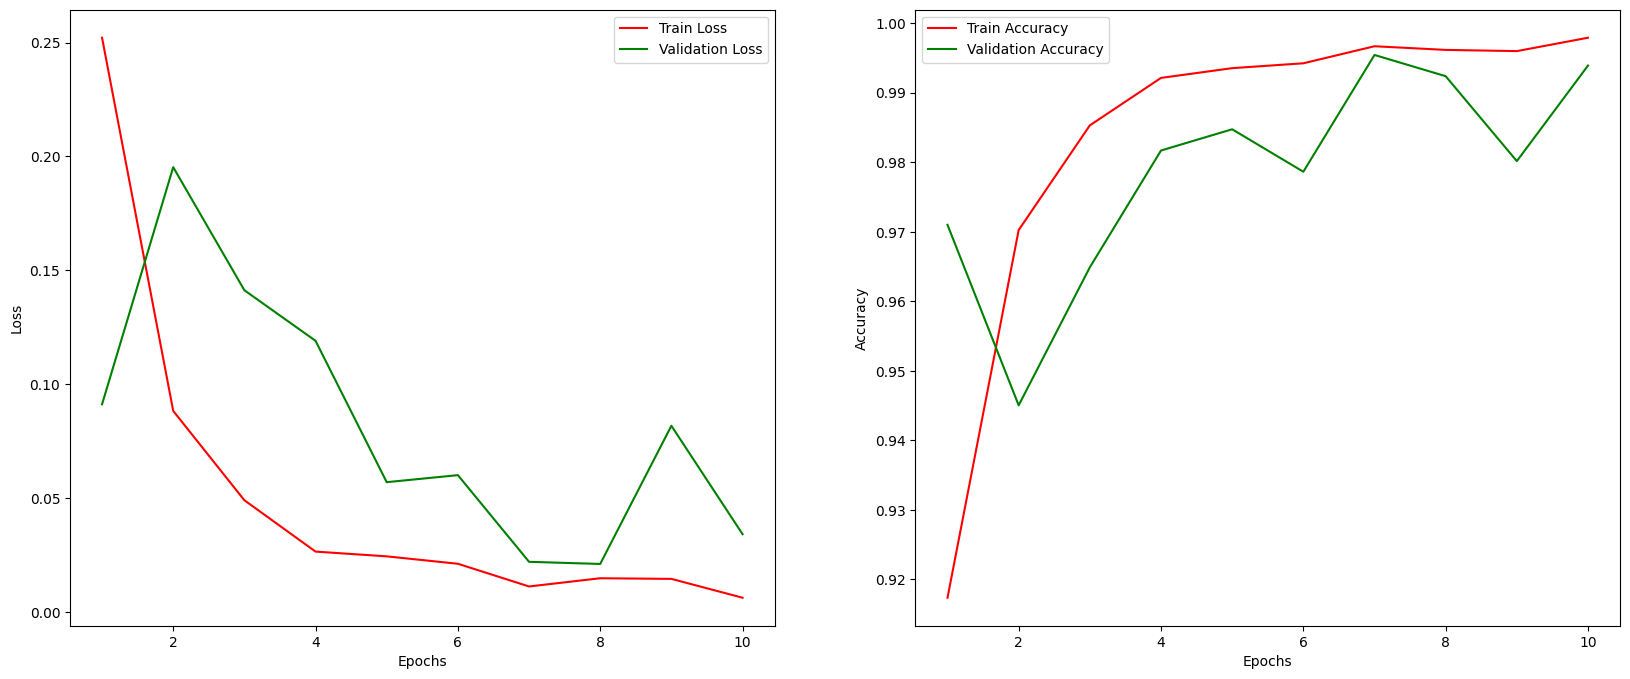

In [ ]:
history = Model.fit(train_gen, epochs=10, validation_data=valid_gen, shuffle=False)

# Plotting Loss & Accuracy
plt.figure(figsize=(20, 8))
epochs = range(1, len(history.history["accuracy"]) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["loss"], "r", label="Train Loss")
plt.plot(epochs, history.history["val_loss"], "g", label="Validation Loss")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["accuracy"], "r", label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], "g", label="Validation Accuracy")
plt.xlabel("Epochs"), plt.ylabel("Accuracy"), plt.legend()

plt.show()

In [15]:
Model.save("/content/drive/My Drive/braintumords/brain_tumor_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [16]:
# Evaluating Performance
train_score = Model.evaluate(train_gen)
valid_score = Model.evaluate(valid_gen)
test_score = Model.evaluate(test_gen)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

357/357 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step - accuracy: 1.0000 - loss: 6.3667e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9917 - loss: 0.0501
41/41 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9997 - loss: 0.0058
Train Accuracy: 99.98%
Validation Accuracy: 99.39%
Test Accuracy: 99.70%


In [19]:
'''pred_probs = Model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)
true_labels = test_gen.classes

# Compute AUC-ROC for each class
auc_roc_dict = {classes[i]: roc_auc_score((true_labels == i).astype(int), pred_probs[:, i]) for i in range(len(classes))}
for class_name, auc_roc in auc_roc_dict.items():
    print(f"AUC-ROC for {class_name}: {auc_roc:.3f}")'''
import numpy as np
from sklearn.metrics import roc_auc_score


pred_probs = Model.predict(test_gen)


true_labels = np.array(test_gen.classes)  # Ensure it's a NumPy array


auc_roc_dict = {classes[i]: roc_auc_score((true_labels == i).astype(int), pred_probs[:, i]) for i in range(len(classes))}


for class_name, auc_roc in auc_roc_dict.items():
    print(f"AUC-ROC for {class_name}: {auc_roc:.3f}")



41/41 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step
AUC-ROC for glioma: 1.000
AUC-ROC for meningioma: 1.000
AUC-ROC for notumor: 1.000
AUC-ROC for pituitary: 1.000



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       1.00      0.99      1.00       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



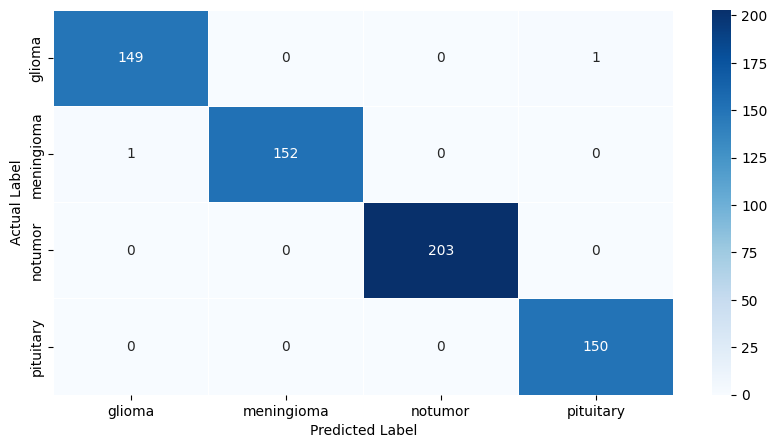

In [20]:
y_pred = np.argmax(pred_probs, axis=1)
# Classification Report
cr = classification_report(true_labels, y_pred)
print(f"\nClassification Report:\n{cr}")

# Confusion Matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(true_labels, y_pred), annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes, cmap="Blues", linewidths=.5)
plt.xlabel('Predicted Label'), plt.ylabel('Actual Label')
plt.show()
